In [67]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [73]:
model_path="yolo11n-det/yolo11n.onnx"
classes_path="yolo11n-det/yolo11n-det.txt"
image_path="../photo/car.jpg"
video_path="../v1.mp4"

In [75]:
print("Current Working Directory:", os.getcwd())
print("config Dosyası Var mı?:", os.path.exists(model_path))
print("class Dosyası Var mı?:", os.path.exists(classes_path))
print("image Dosyası Var mı?:", os.path.exists(image_path))
print("video Dosyası Var mı?:", os.path.exists(video_path))

Current Working Directory: C:\Users\Monster\OneDrive\Masaüstü\OpencvDnn\Onnx
config Dosyası Var mı?: True
class Dosyası Var mı?: True
image Dosyası Var mı?: True
video Dosyası Var mı?: True


In [36]:
# --- Sınıflar ---
with open(classes_path, "r") as f:
    class_names = [cname.strip() for cname in f.readlines()]
num_classes = len(class_names)

In [38]:
# --- Renk paleti ---
np.random.seed(42)
colors = np.random.randint(0, 255, size=(num_classes, 3), dtype="uint8")

In [40]:
net = cv2.dnn.readNetFromONNX(model_path) 

In [42]:
# --- Görüntü ---
image = cv2.imread("car.jpg")
original = image.copy()
h, w = image.shape[:2]

In [44]:
# --- Preprocess ---
blob = cv2.dnn.blobFromImage(image, 1/255.0, (640, 640), swapRB=True, crop=False)
net.setInput(blob)

In [46]:
# --- Tahmin ---
outputs = net.forward()
outputs = np.squeeze(outputs)      # (84, 8400)
outputs = outputs.transpose(1, 0)  # (8400, 84)

In [48]:
# --- Kutular ---
conf_threshold = 0.25
nms_threshold = 0.45
boxes = []
confidences = []
class_ids = []

In [50]:
for det in outputs:
    scores = det[4:]
    class_id = np.argmax(scores)
    confidence = scores[class_id]
    
    if confidence > conf_threshold:
        cx, cy, bw, bh = det[:4]
        x = int((cx - bw / 2) * w / 640)
        y = int((cy - bh / 2) * h / 640)
        bw = int(bw * w / 640)
        bh = int(bh * h / 640)
        boxes.append([x, y, bw, bh])
        confidences.append(float(confidence))
        class_ids.append(class_id)

In [52]:
indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

In [54]:
if len(indices) > 0:
    indices = np.array(indices).flatten()
    for i in indices:
        x, y, bw, bh = boxes[i]
        color = [int(c) for c in colors[class_ids[i]]]
        label = f"{class_names[class_ids[i]]}: {confidences[i]:.2f}"
        cv2.rectangle(original, (x, y), (x + bw, y + bh), color, 2)
        cv2.putText(original, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
else:
    print("Hiçbir nesne tespit edilmedi.")

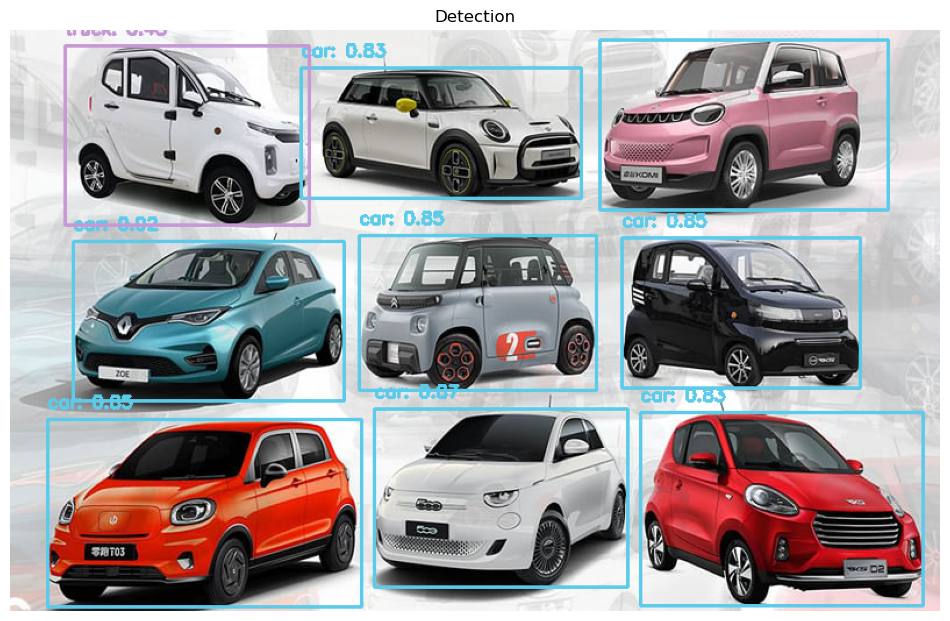

In [56]:
# --- Görüntüle ---
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Detection")
plt.show()


In [77]:
import cv2
import numpy as np

# --- Sınıf isimleri ---
with open(classes_path, "r") as f:
    class_names = [cname.strip() for cname in f.readlines()]
num_classes = len(class_names)

# --- Renk paleti ---
np.random.seed(42)
colors = np.random.randint(0, 255, size=(num_classes, 3), dtype="uint8")

# --- Model yükle ---
net = cv2.dnn.readNetFromONNX(model_path)

# --- Video aç ---
cap = cv2.VideoCapture("../v1.mp4") # Kamerada açmak için 0 yazabilirsin: cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Kamera bağlantısı açılamadı!")
    exit()

conf_threshold = 0.25
nms_threshold = 0.45
input_size = 640

while True:
    ret, frame = cap.read()
    if not ret:
        break

    h, w = frame.shape[:2]

    blob = cv2.dnn.blobFromImage(frame, 1/255.0, (input_size, input_size), swapRB=True, crop=False)
    net.setInput(blob)

    outputs = net.forward()
    outputs = np.squeeze(outputs)
    outputs = outputs.transpose(1, 0)  # (num_preds, 84)

    boxes = []
    confidences = []
    class_ids = []

    for det in outputs:
        scores = det[4:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > conf_threshold:
            cx, cy, bw, bh = det[:4]
            x = int((cx - bw / 2) * w / input_size)
            y = int((cy - bh / 2) * h / input_size)
            bw = int(bw * w / input_size)
            bh = int(bh * h / input_size)

            boxes.append([x, y, bw, bh])
            confidences.append(float(confidence))
            class_ids.append(class_id)

    indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

    if len(indices) > 0:
        indices = np.array(indices).flatten()
        for i in indices:
            x, y, bw, bh = boxes[i]
            color = [int(c) for c in colors[class_ids[i]]]
            label = f"{class_names[class_ids[i]]}: {confidences[i]:.2f}"
            cv2.rectangle(frame, (x, y), (x + bw, y + bh), color, 2)
            cv2.putText(frame, label, (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    cv2.imshow("IP Kamera Detection", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
